In [10]:
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em
import numpy as np
import itertools
import copy
from dwave.samplers import SimulatedAnnealingSampler
import dimod
import psutil
import time
from scipy.sparse import lil_matrix, csc_matrix, block_diag




In [11]:
N_MODULES = 5
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX] * N_MODULES,
    ly=[LY] * N_MODULES,
    z=[i + Z_SPACING for i in range(N_MODULES)]
)

generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi / 6
)

N_PARTICLES = 150
event = generator.generate_event(N_PARTICLES)
event.hits

[Hit(hit_id=0, x=0.11221702536854823, y=-0.12363750426032506, z=1.0, module_id=0, track_id=0),
 Hit(hit_id=5, x=0.31566674107241505, y=0.2642494914083945, z=1.0, module_id=0, track_id=1),
 Hit(hit_id=10, x=0.11935245628820933, y=-0.022624644383053453, z=1.0, module_id=0, track_id=2),
 Hit(hit_id=15, x=-0.003545093135268213, y=-0.34873708078914595, z=1.0, module_id=0, track_id=3),
 Hit(hit_id=20, x=0.4595849318488096, y=0.15432267234414968, z=1.0, module_id=0, track_id=4),
 Hit(hit_id=25, x=-0.1407502694333988, y=0.291324542869651, z=1.0, module_id=0, track_id=5),
 Hit(hit_id=30, x=-0.549209564584994, y=0.0803825439389368, z=1.0, module_id=0, track_id=6),
 Hit(hit_id=35, x=0.3614989525828391, y=0.27121839454504104, z=1.0, module_id=0, track_id=7),
 Hit(hit_id=40, x=0.4610412824645188, y=0.09561057534852499, z=1.0, module_id=0, track_id=8),
 Hit(hit_id=45, x=0.15883321846100013, y=0.2022803886035029, z=1.0, module_id=0, track_id=9),
 Hit(hit_id=50, x=-0.1572711365143559, y=-0.34868582847

In [12]:
params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0,} 

def generate_hamiltonian_optimized(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    modules = sorted(event.modules, key=lambda module: module.z)

    
    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]

    N = len(segments)  

    #initialize sparse block matrices for effviciency
    A_ang_blocks = []
    A_bif_blocks = []
    A_inh_blocks = []
    b = np.zeros(N)

    #total Hamiltonian into smaller blocks->> better for memory
    block_size = 500  
    num_blocks = (N + block_size - 1) // block_size  

    for block_idx in range(num_blocks):
        start_idx = block_idx * block_size
        end_idx = min(start_idx + block_size, N)
        A_ang_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)
        A_bif_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)
        A_inh_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)

        for i in range(start_idx, end_idx):
            seg_i = segments[i]
            vect_i = seg_i.to_vect()
            norm_i = np.linalg.norm(vect_i)

            for j in range(i + 1, end_idx):  #
                seg_j = segments[j]
                vect_j = seg_j.to_vect()
                norm_j = np.linalg.norm(vect_j)

                cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)
                if np.abs(cosine - 1) < 1e-9:
                    A_ang_block[i - start_idx, j - start_idx] = 1
                    A_ang_block[j - start_idx, i - start_idx] = 1  # Symmetry with positive sign

                if seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit:
                    A_bif_block[i - start_idx, j - start_idx] = -alpha
                    A_bif_block[j - start_idx, i - start_idx] = -alpha  # Symmetry with negative sign

                if seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit:
                    A_bif_block[i - start_idx, j - start_idx] = -alpha
                    A_bif_block[j - start_idx, i - start_idx] = -alpha  # Symmetry with negative sign

                s_ab = int(seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1)
                if s_ab > 0:
                    A_inh_block[i - start_idx, j - start_idx] = beta * s_ab * s_ab
                    A_inh_block[j - start_idx, i - start_idx] = beta * s_ab * s_ab  # Symmetry with positive sign

        A_ang_blocks.append(A_ang_block)
        A_bif_blocks.append(A_bif_block)
        A_inh_blocks.append(A_inh_block)


    A_ang = block_diag(A_ang_blocks, format='csc')
    A_bif = block_diag(A_bif_blocks, format='csc')
    A_inh = block_diag(A_inh_blocks, format='csc')

    A = -1 * (A_ang + A_bif + A_inh)

    return A, b, segments


process = psutil.Process()

start_memory = process.memory_info().rss / (1024 ** 2)  
start_time = time.time()

A, b, segments = generate_hamiltonian_optimized(event, params)
end_memory = process.memory_info().rss / (1024 ** 2)  
end_time = time.time()

memory_used = end_memory - start_memory
time_taken = end_time - start_time

print(f"Memory used: {memory_used:.2f} MB")
print(f"Time taken: {time_taken:.6f} seconds")

Memory used: 312.61 MB
Time taken: 353.534856 seconds


In [26]:
!pip install ace_tools

Matrix size: 100, Density: 0.01, Memory used: 0.01 MB, Sparsity: 0.9900, Time: 0.0220s
Matrix size: 100, Density: 0.05, Memory used: 0.01 MB, Sparsity: 0.9500, Time: 0.0090s
Matrix size: 100, Density: 0.10, Memory used: 0.02 MB, Sparsity: 0.9000, Time: 0.0100s
Matrix size: 100, Density: 0.20, Memory used: 0.03 MB, Sparsity: 0.8000, Time: 0.0140s
Matrix size: 500, Density: 0.01, Memory used: 0.17 MB, Sparsity: 0.9900, Time: 0.0439s
Matrix size: 500, Density: 0.05, Memory used: 0.11 MB, Sparsity: 0.9500, Time: 0.0649s
Matrix size: 500, Density: 0.10, Memory used: 0.34 MB, Sparsity: 0.9000, Time: 0.1043s
Matrix size: 500, Density: 0.20, Memory used: 0.39 MB, Sparsity: 0.8000, Time: 0.1600s
Matrix size: 1000, Density: 0.01, Memory used: 0.23 MB, Sparsity: 0.9900, Time: 0.1192s
Matrix size: 1000, Density: 0.05, Memory used: 0.54 MB, Sparsity: 0.9500, Time: 0.2313s
Matrix size: 1000, Density: 0.10, Memory used: 0.92 MB, Sparsity: 0.9000, Time: 0.3849s
Matrix size: 1000, Density: 0.20, Memory

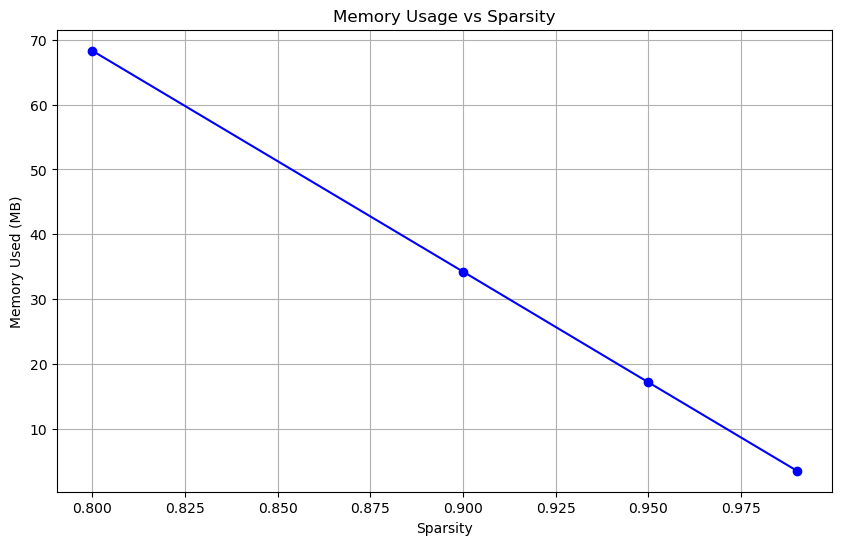

In [1]:
import numpy as np
import psutil
import time
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random
from scipy.sparse import csc_matrix
import pandas as pd
import gc
import tracemalloc


def generate_random_sparse_matrix(size, density):
    
    sparse_matrix = sparse_random(size, size, density=density, format='lil', dtype=np.float32)
    return csc_matrix(sparse_matrix)

def test_memory_vs_sparsity(matrix_sizes, densities):
    process = psutil.Process()
    results = []

    for size in matrix_sizes:
        for density in densities:
            gc.collect()
            tracemalloc.start()

            start_time = time.time()
            snapshot1 = tracemalloc.take_snapshot()

            
            A = generate_random_sparse_matrix(size, density)

            snapshot2 = tracemalloc.take_snapshot()
            end_time = time.time()

            tracemalloc.stop()

            stats = snapshot2.compare_to(snapshot1, 'lineno')
            total_memory = sum([stat.size_diff for stat in stats]) / (1024 ** 2)  # Convert to MB
            time_taken = end_time - start_time
            sparsity = 1 - (A.count_nonzero() / (A.shape[0] * A.shape[1]))
            results.append((size, density, total_memory, sparsity, time_taken))
            print(f"Matrix size: {size}, Density: {density:.2f}, Memory used: {total_memory:.2f} MB, Sparsity: {sparsity:.4f}, Time: {time_taken:.4f}s")

    
    df = pd.DataFrame(results, columns=["Matrix Size", "Density", "Memory Used (MB)", "Sparsity", "Time Taken (s)"])
    return df

matrix_sizes = [100, 500, 1000, 1500, 2000, 5000, 10000, 15000]  
densities = [0.01, 0.05, 0.1,  0.2]  

df = test_memory_vs_sparsity(matrix_sizes, densities)

plt.figure(figsize=(10, 6))
df_grouped = df.groupby("Sparsity").mean().reset_index()

plt.plot(df_grouped['Sparsity'], df_grouped['Memory Used (MB)'], marker='o', linestyle='-', color='b')

plt.xlabel('Sparsity')
plt.ylabel('Memory Used (MB)')
plt.title('Memory Usage vs Sparsity')


plt.grid(True)
plt.show()



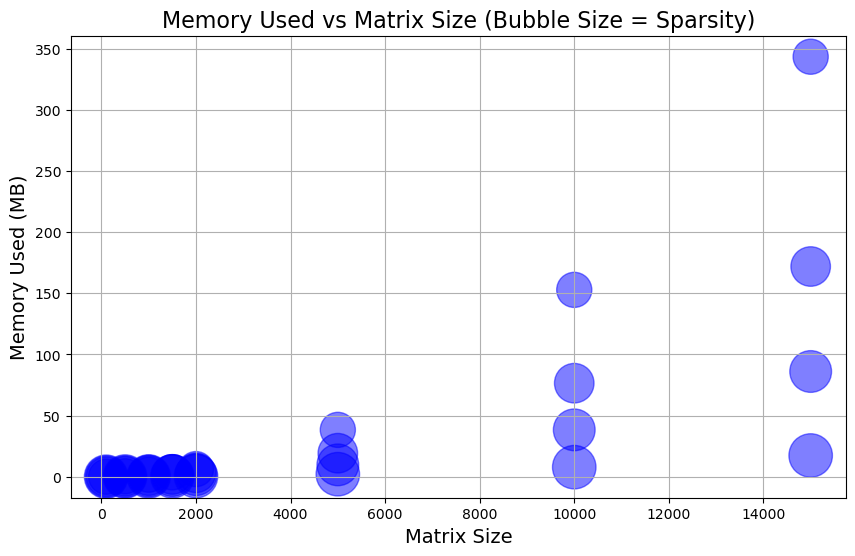

In [5]:
# Bubble plot
plt.figure(figsize=(10, 6))
bubble_sizes = (df['Sparsity'] ** 2) * 1000


plt.scatter(df['Matrix Size'], df['Memory Used (MB)'], s=bubble_sizes, alpha=0.5, color='b')


plt.xlabel('Matrix Size', fontsize=14)
plt.ylabel('Memory Used (MB)', fontsize=14)
plt.title('Memory Used vs Matrix Size (Bubble Size = Sparsity)', fontsize=16)

plt.grid(True)
plt.show()



Matrix size: 10000x10000, Block size: 50, Memory used: 3.06 MB, Sparsity: 0.9997, Time: 0.6223s
Matrix size: 10000x10000, Block size: 100, Memory used: 4.63 MB, Sparsity: 0.9995, Time: 0.9285s
Matrix size: 10000x10000, Block size: 200, Memory used: 7.72 MB, Sparsity: 0.9990, Time: 1.2207s
Matrix size: 10000x10000, Block size: 500, Memory used: 20.09 MB, Sparsity: 0.9975, Time: 2.9631s
Matrix size: 10000x10000, Block size: 1000, Memory used: 48.52 MB, Sparsity: 0.9950, Time: 6.1969s
Matrix size: 10000x10000, Block size: 2000, Memory used: 130.50 MB, Sparsity: 0.9900, Time: 12.0967s


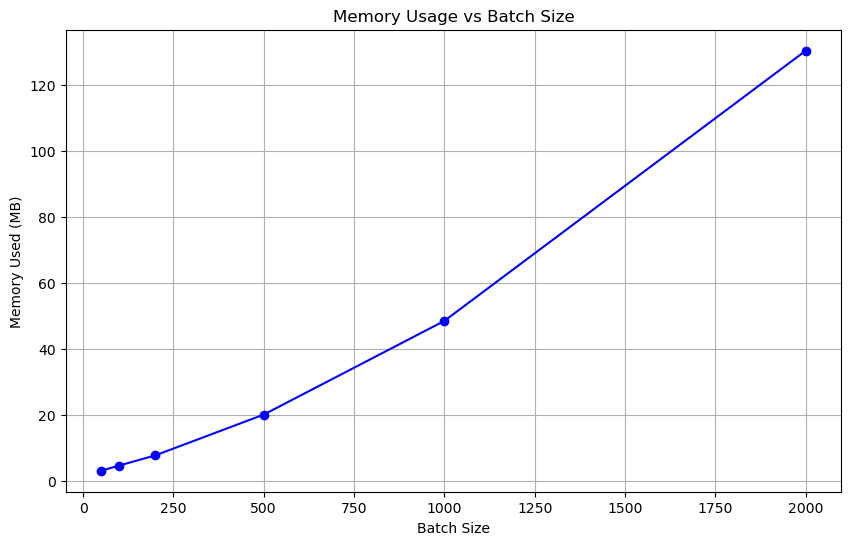

In [5]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, block_diag
import pandas as pd
import tracemalloc

# Function to generate a blockwise random sparse matrix with a given block size and density
def generate_blockwise_sparse_matrix(size, density, block_size):
    """Generates a random sparse matrix in blocks with given block size and density."""
    # Number of blocks
    num_blocks = (size + block_size - 1) // block_size  # Calculate number of blocks

    # List to store block matrices
    block_matrices = []

    # Generate each block as a sparse matrix
    for _ in range(num_blocks):
        block = lil_matrix((block_size, block_size), dtype=np.float32)
        # Randomly fill the block with a given density
        block[:] = np.random.choice([0, 1], size=(block_size, block_size), p=[1-density, density])
        block_matrices.append(block)

    # Combine the blocks into a block diagonal matrix
    return block_diag(block_matrices, format='csc')

# Function to test memory usage for different block sizes
def test_memory_vs_block_size(matrix_size, density, block_sizes):
    results = []

    for block_size in block_sizes:
        # Start tracing memory allocations
        tracemalloc.start()
        start_time = time.time()

        # Generate a blockwise random sparse matrix with the given block size
        A = generate_blockwise_sparse_matrix(matrix_size, density, block_size)

        # Stop tracing memory allocations
        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        # Calculate memory used and time taken
        memory_used = peak / (1024 ** 2)  # Convert bytes to MB
        time_taken = end_time - start_time

        # Calculate sparsity
        sparsity = 1 - (A.count_nonzero() / (A.shape[0] * A.shape[1]))

        # Append the result for this test case
        results.append((A.shape[0], block_size, memory_used, sparsity, time_taken))
        print(f"Matrix size: {A.shape[0]}x{A.shape[1]}, Block size: {block_size}, Memory used: {memory_used:.2f} MB, Sparsity: {sparsity:.4f}, Time: {time_taken:.4f}s")

    # Convert the results into a pandas DataFrame for analysis and plotting
    df = pd.DataFrame(results, columns=["Matrix Size N", "Block Size", "Memory Used (MB)", "Sparsity", "Time Taken (s)"])
    return df

# Define matrix size, density, and block sizes to test
matrix_size = 10000  # Fixed matrix size
density = 0.05  # Fixed density (5% non-zero elements)
block_sizes = [50, 100, 200, 500, 1000, 2000]  # Test different block sizes

# Test memory usage for different block sizes
df = test_memory_vs_block_size(matrix_size, density, block_sizes)

import matplotlib.pyplot as plt

# Plot Memory Usage vs Batch Size
plt.figure(figsize=(10, 6))
plt.plot(block_sizes, df['Memory Used (MB)'], marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Batch Size')
plt.ylabel('Memory Used (MB)')
plt.title('Memory Usage vs Batch Size')

# Show grid
plt.grid(True)

# Display the plot
plt.show()


